In [163]:
import gzip
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random, heapq

In [178]:
data = []
userRatings = defaultdict(list)

def readGz(f):
    for l in gzip.open(f):
        yield eval(l)

def readFile(f):
    for l in open(f):
        yield eval(l)
#training and validation 
for l in readFile("train.json"):
    data.append(l)

print("Data length: " , len(data))
df = pd.DataFrame.from_dict(data)


validation_neg_pairs = set()
for l in open("pairs_Purchase.txt",'r'):
    if l.startswith("reviewerID"):
        #header
        continue
    u,i = l.strip().split('-')
    validation_neg_pairs.add((u,i))


Data length:  200000


In [165]:
#Most reviewed items
items_count = df['itemID'].value_counts()
items_count

I835857013    227
I964877831    210
I431429328    196
I359425229    196
I408729378    175
             ... 
I875289577      1
I237366629      1
I302619354      1
I345911319      1
I082607986      1
Name: itemID, Length: 19914, dtype: int64

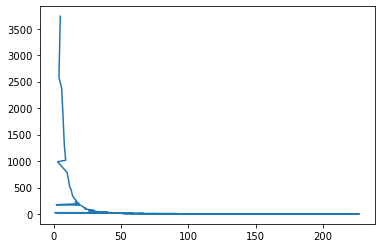

In [166]:
items_count.value_counts().plot()

In [167]:
Popularity = 20

In [168]:
item_cat_df = df[['categories','itemID']]
df_item_uniqcat = item_cat_df.drop_duplicates(subset=['itemID'])
df_item_uniqcat.set_index('itemID',inplace=True)

In [169]:
def flatten_category(original_list):
    item_cat_set = set()
    for subcat in original_list:
        for cat_str in subcat:
            item_cat_set.add(cat_str)
    return item_cat_set

In [170]:
item_to_cat = {}  # itemID to set of string

for idx,row in df_item_uniqcat.iterrows():
    if idx not in item_to_cat:
        item_to_cat[idx] = set()
    item_to_cat[idx] |= flatten_category(row['categories'])

In [171]:
user_to_cat = {}  # userID to set of strings

for idx, row in df.iterrows():
    userId,itemId = row['reviewerID'],row['itemID']
    
    if userId not in user_to_cat:
        user_to_cat[userId] = set()
        
    user_to_cat[userId] |= item_to_cat[itemId]

In [172]:
common_strings = 5

In [173]:
def similarity(item_cat,user_cat):
    return len(item_cat & user_cat) > common_strings \
    or float(len(item_cat & user_cat)) / len(item_cat | user_cat)

In [174]:
def predictor_category(itemID, userID):
    # check for Item and User
    if itemId not in item_to_cat or userId not in user_to_cat:
        return False 
    # predict based on similarity
    return similarity(item_to_cat[itemId],user_to_cat[userId]) > Jac

In [175]:
Jac = 0.17

In [176]:
popular_item_count = items_count[items_count > Popularity]
print("popular items: ", len(popular_item_count))

popular items:  1742


In [177]:
predictions = open("predictions_Purchase.txt", 'w')
predicted_true = 0
predicted_false = 0
lines = 0

for l in open("pairs_Purchase.txt"):
    lines += 1
    if l.startswith("reviewerID"):
        #header
        predictions.write(l)
        continue
    u,i = l.strip().split('-')

    # check the first predictor, if user purchased this category before 
    if i in popular_item_count:
        predictions.write(u + '-' + i + ",1\n")
        predicted_true += 1
    else:
        if predictor_category(i, u):
            predictions.write(u + '-' + i + ",1\n")
            predicted_true += 1
        else:
            predictions.write(u + '-' + i + ",0\n")
            predicted_false += 1

predictions.close()